In [1]:
import numpy as np

from scipy import constants
from matplotlib import pyplot as plt

import optical_modulation as omod

from light_source import LightSource
from optical_fiber import OpticalFiber
from photodetector import Photodector

In [2]:
figfolder = "../../figures/"

In [3]:
central_frequency = 194e12                                                         # 194 THz
frequency_linewidth = 3e3                                                          # 3 KHz

source = LightSource(
        frequency=central_frequency,
        frequency_linewidth=frequency_linewidth,
        power=1e-3,                                                                 # 1 mW = 0 dBm
        frequency_step=250,                                                         # 250 Hz
        bandwidth=8 * frequency_linewidth,
        shape="lorentzian",
    )

In [4]:
pulse_width = 1e-9        # 1 ns
segment_duration = 1e-11
rise_time = pulse_width / 10

time = omod.get_pulse_time_array(pulse_width, segment_duration, rise_time)
sine_pulse = omod.get_sine_rectangular_pulse(pulse_width, time, rise_time)

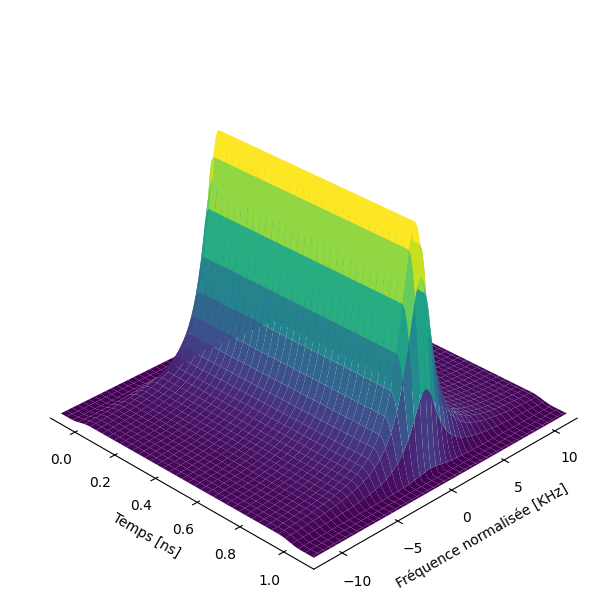

In [5]:
distribution = np.outer(source.normalized_lineshape, sine_pulse)
TIME, FREQ = np.meshgrid(time, source.frequencies, )

fig = plt.figure(figsize=(8, 6), layout="constrained")
ax = fig.add_subplot(111, projection='3d')

TIME *= 1e9
FREQ = (FREQ - source.frequency) / 1e3

ax.plot_surface(TIME, FREQ, distribution, cmap='viridis', linewidth=0)

ax.set_xlabel("Temps [ns]")
ax.set_ylabel("Fréquence normalisée [KHz]")
ax.set_xlim(TIME.min(), TIME.max())
ax.set_ylim(FREQ.min(), FREQ.max())

ax.set_facecolor('white')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_visible(False)
ax.zaxis.set_visible(False)
ax.zaxis.set(ticks=[])
ax.grid(visible=False)
ax.view_init(elev=30, azim=-45, roll=0)

plt.savefig(figfolder + "time_frequency_distribution.pdf")
plt.show()

In [6]:
fiber = OpticalFiber(
    refractive_index=1.44,
    refractive_index_variation=1e-7,
    attenuation_coefficient=0.2,  # 0.2 dB / km
    segment_size=1e-2,  # 1 cm
    segment_size_variation=5,  # 5 %
    mode_field_diameter=2.13,
    average_backscattering_field_coefficient=70,
    length=10e3,  # 10 km
)

detector = Photodector(responsitivity=1,    # Ideal
                       bandwidth=100e6        # 100 MHz
)